### Example F
Herein, we demonstrate how to use thermal energy storage tank with flexible operational strategy based on diurnal changes in flow rates.

In [1]:
# Only needed when FGEM is NOT installed by user
import sys
sys.path.insert(1, '../')

from fgem.world import World
from fgem.utils.config import get_config_from_json
from tqdm import tqdm

import numpy as np

In [2]:
def tank_step_update_record(project, m_prd=130, charge_time=(8, 14), discharge_time=(17, 23)):
    
    # UPDATE: we first update project state (also, we override parameters if needed)
    if (project.time_curr.hour >= charge_time[0]) and (project.time_curr.hour <= charge_time[1]):
        max_charge_mass = project.st.mass_max_charge/project.timestep.total_seconds()
        m_tes_in = np.clip(m_prd * project.num_prd, 0, max_charge_mass)
        m_tes_out = 0
        m_prd = np.maximum(m_prd, m_tes_in/project.num_prd * np.ones(project.num_prd))
        
    elif (project.time_curr.hour >= discharge_time[0]) and (project.time_curr.hour <= discharge_time[1]):
        max_discharge_mass = project.st.mass_max_discharge/project.timestep.total_seconds()
        m_tes_out = max_discharge_mass
        m_tes_in = 0
        m_prd = np.maximum(m_prd -  m_tes_out/project.num_prd, 10)
        
    else:
        m_tes_in, m_tes_out = 0, 0
        
    project.update_state(m_prd, m_tes_out=m_tes_out, m_tes_in=m_tes_in)
    
    # STEP: step power plant and reservoir
    T_inj = project.T_inj
    T_amb = project.T_amb
    m_turbine = project.m_g
    T_prd_wh = project.reservoir.T_prd_wh.mean()
    
    # step TES
    m_tes_in, m_tes_out, violation = project.st.step(T_amb, m_tes_in, m_tes_out, T_prd_wh)
    T_tes_out = project.st.Tw
            
    # step powerplant
    project.powerplant.step(m_turbine=m_turbine, 
                            T_prd_wh=T_prd_wh, 
                            T_tes_out=T_tes_out,
                            T_amb=T_amb)
    # step reservoir
    project.reservoir.step(m_prd=m_prd,
                        T_inj=T_inj,
                        T_amb=T_amb)
    
    # RECORD: store the current project timestep
    project.record_step()

In [3]:
# Read configuration file
config = get_config_from_json('configs/exampleF.json')

project = World(config)

# Iterate over project lifetime
for i in tqdm(range(project.max_simulation_steps)):
     tank_step_update_record(project)

# Compute economics and summary results
project.compute_economics(print_outputs=False)


https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations


  0%|          | 0/10950 [00:00<?, ?it/s]

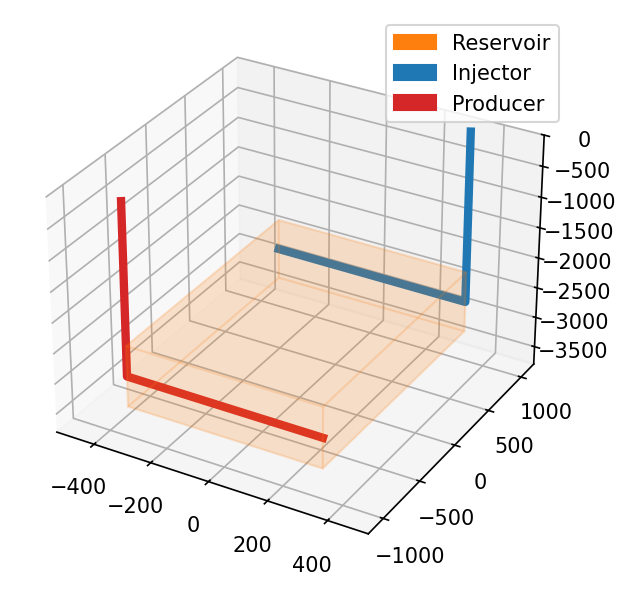

In [4]:
fig = project.reservoir.plot_doublet()

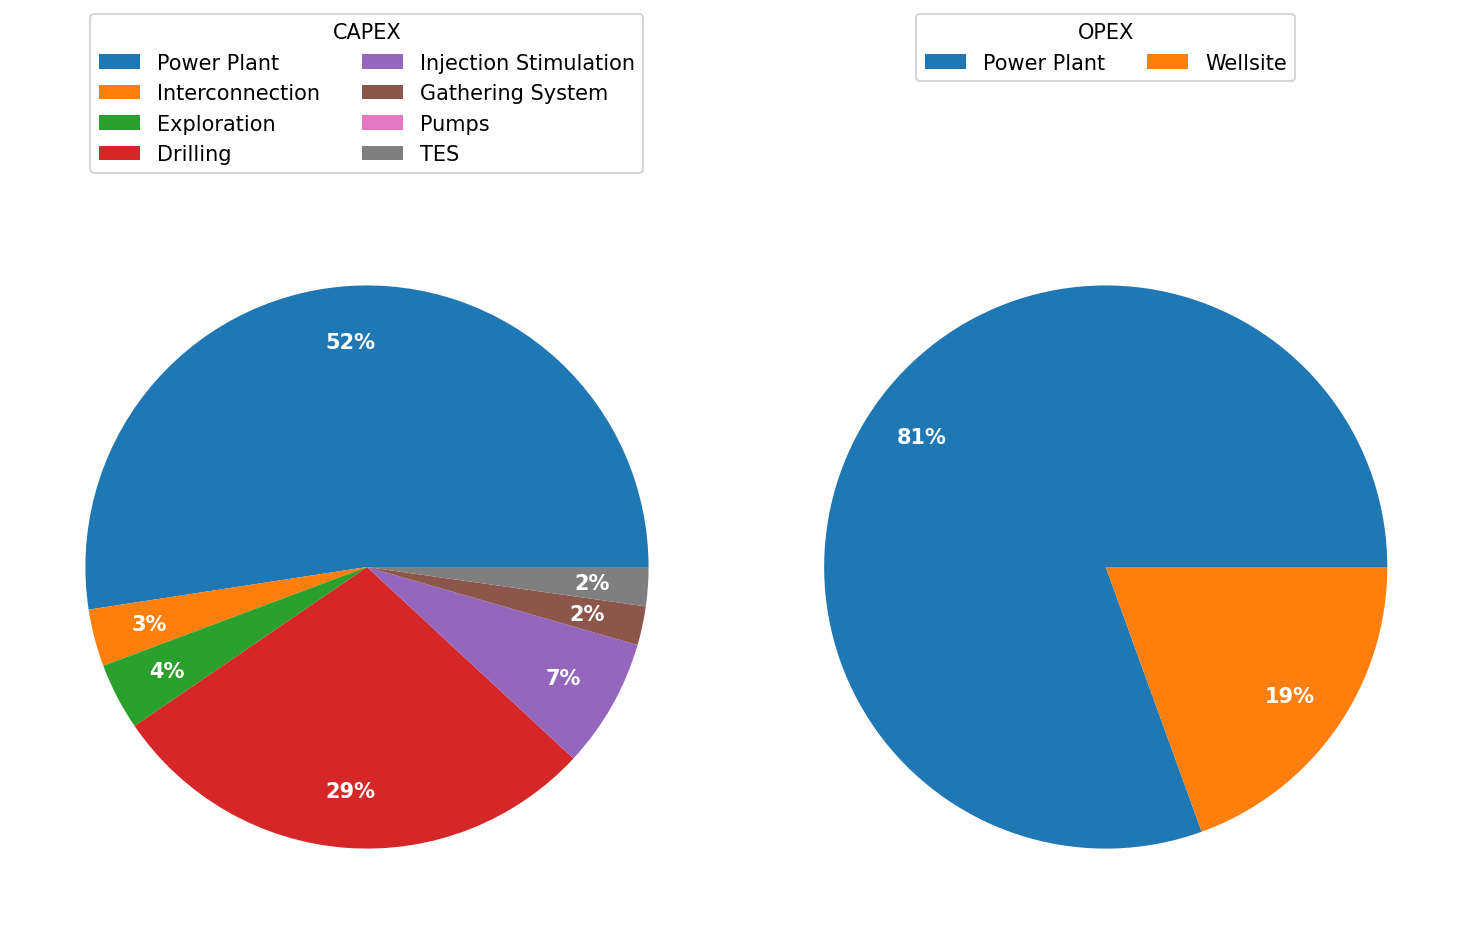

In [5]:
fig = project.plot_economics()

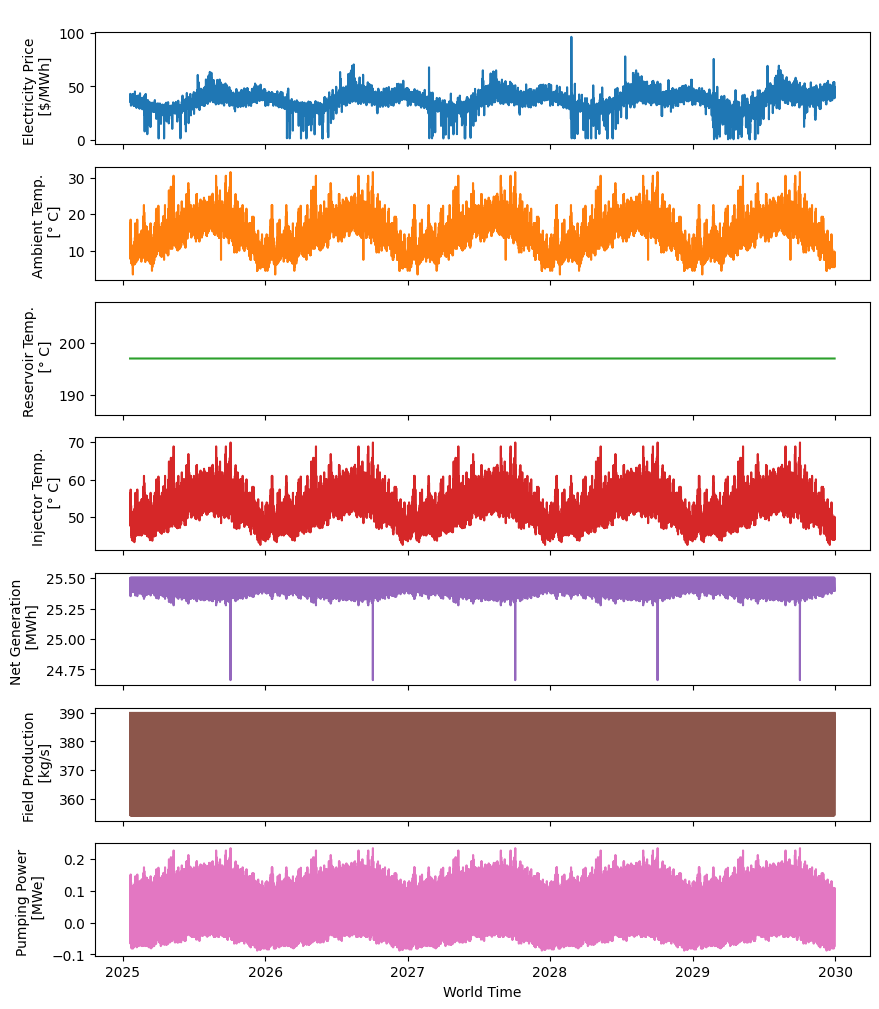

In [6]:
fig = project.plot_operations()